In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats

import ncar_jobqueue
from dask.distributed import Client

### Define CESM case

In [2]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'
variables = ['CaCO3_FLUX_IN'] 

### Get CaCO3 flux in

In [3]:
%%time

ds_list = []

print(f'reading {case}')

ds = xr.Dataset()

for v in variables:
    
    print(v)
    
    #files = sorted(glob(f'{path}/{case}.pop.h.{v}.??????-??????.nc'))       
    files = sorted(glob(f'{path}/{case}.pop.h.ecosys.nyear1.{v}.0249-0310.nc'))

    print(files)
    
    #dsv = xr.open_mfdataset(files, decode_times=True, decode_coords=False)
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading cesm22cocco.G1850ECOIAF.T62_g17.003
CaCO3_FLUX_IN
['/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/tseries/year_1/cesm22cocco.G1850ECOIAF.T62_g17.003.pop.h.ecosys.nyear1.CaCO3_FLUX_IN.0249-0310.nc']
CPU times: user 61.2 ms, sys: 13.9 ms, total: 75.1 ms
Wall time: 460 ms


In [4]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

### get potential density

In [5]:
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
variables = ['PD']

In [6]:
%%time

ds_list = []

print(f'reading {case}')

ds_mon = xr.Dataset()

for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.024901-031012.nc'))       

    #print(files)
    
    #dsv = xr.open_mfdataset(files, decode_times=True, decode_coords=False)
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds_mon = xr.merge((ds_mon, dsv))
    ds_list.append(ds_mon)

reading cesm22cocco.G1850ECOIAF.T62_g17.003
PD
CPU times: user 68 ms, sys: 10.6 ms, total: 78.6 ms
Wall time: 225 ms


In [7]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds_mon = ds_mon.drop([v for v in ds_mon.variables if v not in keep_vars])

In [8]:
ds_ann_pd = ds_mon.mean(dim='time')
ds_ann_pd

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    TLONG        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    REGION_MASK  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz           (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    PD           (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>

In [9]:
cesm_ann_ds=ds.mean(dim='time')

In [10]:
cesm_ann_ds['PD']=ds_ann_pd['PD']

In [11]:
cesm_ann_ds

<xarray.Dataset>
Dimensions:        (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t_150m       (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * z_t            (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    REGION_MASK    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz             (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    CaCO3_FLUX_IN  (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    PD             (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>

### get Alk with noGCB

In [12]:
outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/mean5thIAF/annual_means.nc'
# #cesm_ann_ds.to_netcdf(outfile)
ds = xr.open_dataset(outfile,decode_times=False,decode_coords=False)

In [13]:
cesm_ann_ds['ALK'] = ds['ALK']
cesm_ann_ds['ALK_ALT_CO2_noGCB'] = ds['ALK_ALT_CO2']

### get Alk with 2x GCB

In [14]:
outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.004/ocn/proc/mean5thIAF/mean_IAF5_alkalt_004.nc'

ds = xr.open_dataset(outfile,decode_times=False,decode_coords=False)


In [15]:
cesm_ann_ds['ALK_ALT_CO2_2xGCB'] = ds['ALK_ALT_CO2']

### compute sigma densities

In [16]:
cesm_ann_ds['sigma'] = cesm_ann_ds.PD * 1000. - 1000.

### Make ALK diff

In [17]:
cesm_ann_ds['ALK_diff_noGCB'] = cesm_ann_ds.ALK_ALT_CO2_noGCB - cesm_ann_ds.ALK
cesm_ann_ds['ALK_diff_2xGCB'] = cesm_ann_ds.ALK_ALT_CO2_2xGCB - cesm_ann_ds.ALK

### Now DS has everything we need

In [18]:
cesm_ann_ds

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    TLONG              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t_150m           (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_t                (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    REGION_MASK        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz                 (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    CaCO3_FLUX_IN      (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    PD                 (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    ALK                (z_t, nlat, nlon) float32 ...
    ALK_ALT_CO2_noGCB  (z_t, nlat, nlon) float32 ...
    ALK_ALT_CO2_2xGCB  (z_t, nlat, nlon) float32 ...
    sigma              (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    ALK_diff_noGCB     (z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan
    ALK_diff_2xGCB     (z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan

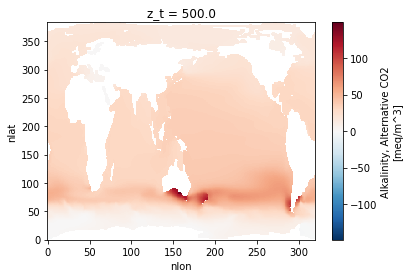

In [19]:
cesm_ann_ds.ALK_diff_noGCB.isel(z_t=0).plot()

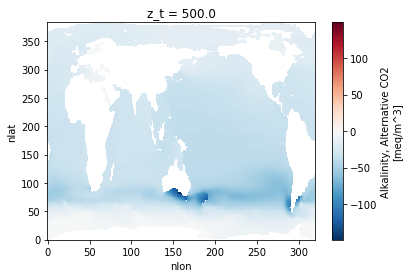

In [20]:
cesm_ann_ds.ALK_diff_2xGCB.isel(z_t=0).plot()

In [21]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = cesm_ann_ds.z_t

In [22]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
area_m=ds_woa.TAREA * 1e-4
depths_m=ds_woa.z_t * 0.01
dz=cesm_ann_ds.dz
dz_m=cesm_ann_ds.dz * 0.01

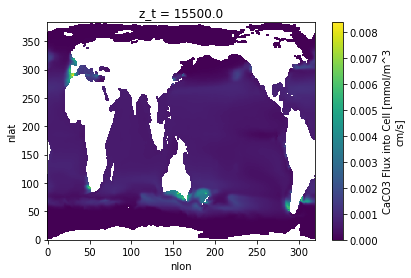

In [23]:
cesm_ann_ds.CaCO3_FLUX_IN.isel(z_t=15).plot()

In [24]:
sigma_surf=cesm_ann_ds['sigma'].isel(z_t=0)

In [25]:
# SAZ_ds.ALK.attrs={'long_name': 'Alkalinity',
#  'units': 'meq/m^3',
#  'grid_loc': '3111',
#  'cell_methods': 'time: mean'}
# SAZ_ds.ALK_ALT_CO2_noGCB.attrs={'long_name': 'Alkalinity',
#  'units': 'meq/m^3',
#  'grid_loc': '3111',
#  'cell_methods': 'time: mean'}
# SAZ_ds.ALK_ALT_CO2_2xGCB.attrs={'long_name': 'Alkalinity',
#  'units': 'meq/m^3',
#  'grid_loc': '3111',
#  'cell_methods': 'time: mean'}
# SAZ_ds.ALK_diff_noGCB.attrs={'long_name': 'Alkalinity',
#  'units': 'meq/m^3',
#  'grid_loc': '3111',
#  'cell_methods': 'time: mean'}
# SAZ_ds.ALK_diff_2xGCB.attrs={'long_name': 'Alkalinity',
#  'units': 'meq/m^3',
#  'grid_loc': '3111',
#  'cell_methods': 'time: mean'}

In [26]:
outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/mean5thIAF/mean_IAF5_GCB_CaCO3flux.nc'
#SAZ_ds.to_netcdf(outfile)
SAZ_ds = xr.open_dataset(outfile,decode_times=False,decode_coords=False)

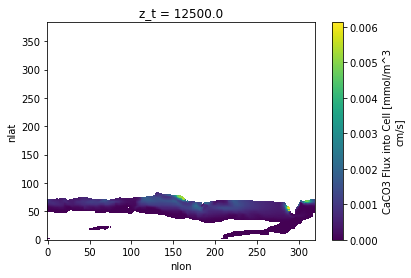

In [27]:
SAZ_ds.CaCO3_FLUX_IN.isel(z_t=12).plot()

### Calculate ALK for deep waters for noGCB experiment

In [28]:
#SAZ_ALK_noGCB_bottom = SAZ_ds.ALK_ALT_CO2_noGCB.where(SAZ_ds.sigma>27.4)
glb_ALK_noGCB_bottom = cesm_ann_ds.ALK_ALT_CO2_noGCB.where(cesm_ann_ds.sigma>27.4)
#dims: z_t,nlat,nlon

In [29]:
%%time
#SAZ_ALK_noGCB_bottom = esmlab.weighted_sum(SAZ_ALK_noGCB_bottom, weights=area_m, dim=['nlat', 'nlon']).compute()
glb_ALK_noGCB_bottom = esmlab.weighted_sum(glb_ALK_noGCB_bottom, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t

CPU times: user 1min 42s, sys: 18.5 s, total: 2min
Wall time: 2min 1s


In [30]:
#SAZ_ALK_noGCB_bottom = esmlab.weighted_sum(SAZ_ALK_noGCB_bottom, weights=dz_m, dim=['z_t']).compute()
glb_ALK_noGCB_bottom = esmlab.weighted_sum(glb_ALK_noGCB_bottom, weights=dz_m, dim=['z_t']).compute()
#dims: none

In [31]:
#SAZ_ALK_noGCB_bottom = SAZ_ALK_noGCB_bottom.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
#SAZ_ALK_noGCB_bottom

In [32]:
glb_ALK_noGCB_bottom = glb_ALK_noGCB_bottom.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
glb_ALK_noGCB_bottom

2521.756321437857

### Calculate Ocean Volume

In [33]:
volume = area_m * dz_m

In [34]:
volume = volume.where(cesm_ann_ds.sigma>0.)

In [35]:
volume_tot = volume.sum(dim=['z_t','nlat','nlon'])

In [36]:
volume_tot = volume_tot * 1.e-9 #convert from m3 to km3
volume_tot.values #should be ~1.35e9

array(1.3251214e+09)

#### upper/deep volumes

In [37]:
#get volume of "upper ocean"
volume_upper = volume.where(cesm_ann_ds.sigma<=27.4)
volume_upper_tot = volume_upper.sum(dim=['z_t','nlat','nlon'])
volume_upper_tot = volume_upper_tot * 1.e-9 #convert from m3 to km3
volume_upper_tot.values

array(2.88890642e+08)

In [38]:
#get volume of "deep ocean"
volume_deep = volume.where(cesm_ann_ds.sigma>27.4)
volume_deep_tot = volume_deep.sum(dim=['z_t','nlat','nlon'])
volume_deep_tot = volume_deep_tot * 1.e-9 #convert from m3 to km3
volume_deep_tot.values

array(1.03623076e+09)

#### N/S of 45°S

In [39]:
#get volume ocean north of 45S
volume_N45 = volume.where(cesm_ann_ds.sigma>0.).where(lats>-45.)
volume_N45_tot = volume_N45.sum(dim=['z_t','nlat','nlon'])
volume_N45_tot = volume_N45_tot * 1.e-9 #convert from m3 to km3
volume_N45_tot.values

array(1.09805211e+09)

In [40]:
#get volume of ocean south of 45S
volume_S45 = volume.where(cesm_ann_ds.sigma>0.).where(lats<=-45.)
volume_S45_tot = volume_S45.sum(dim=['z_t','nlat','nlon'])
volume_S45_tot = volume_S45_tot * 1.e-9 #convert from m3 to km3
volume_S45_tot.values

array(2.27069288e+08)

### Calculate ALK  for upper waters for noGCB experiment

In [41]:
#SAZ_ALK_noGCB_top = SAZ_ds.ALK_ALT_CO2_noGCB.where(SAZ_ds.sigma<=27.4)
glb_ALK_noGCB_top = cesm_ann_ds.ALK_ALT_CO2_noGCB.where(cesm_ann_ds.sigma<=27.4)
#dims: z_t,nlat,nlon

In [42]:
%%time
#SAZ_ALK_noGCB_top = esmlab.weighted_sum(SAZ_ALK_noGCB_top, weights=area_m, dim=['nlat', 'nlon']).compute()
glb_ALK_noGCB_top = esmlab.weighted_sum(glb_ALK_noGCB_top, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t

CPU times: user 1min 44s, sys: 21 s, total: 2min 5s
Wall time: 2min 5s


In [43]:
%%time
#SAZ_ALK_noGCB_top = esmlab.weighted_sum(SAZ_ALK_noGCB_top, weights=dz_m, dim=['z_t']).compute()
glb_ALK_noGCB_top = esmlab.weighted_sum(glb_ALK_noGCB_top, weights=dz_m, dim=['z_t']).compute()
#dims: none

CPU times: user 16.3 ms, sys: 4.24 ms, total: 20.5 ms
Wall time: 24.1 ms


In [44]:
#SAZ_ALK_noGCB_top = SAZ_ALK_noGCB_top.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
#SAZ_ALK_noGCB_top

In [45]:
glb_ALK_noGCB_top = glb_ALK_noGCB_top.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
glb_ALK_noGCB_top

690.0940664232062

### Calculate ALK for deep waters for 2xGCB experiment

In [46]:
#SAZ_ALK_2xGCB_bottom = SAZ_ds.ALK_ALT_CO2_2xGCB.where(SAZ_ds.sigma>27.4)
glb_ALK_2xGCB_bottom = cesm_ann_ds.ALK_ALT_CO2_2xGCB.where(cesm_ann_ds.sigma>27.4)
#dims: z_t,nlat,nlon

In [47]:
%%time
#SAZ_ALK_2xGCB_bottom = esmlab.weighted_sum(SAZ_ALK_2xGCB_bottom, weights=area_m, dim=['nlat', 'nlon']).compute()
glb_ALK_2xGCB_bottom = esmlab.weighted_sum(glb_ALK_2xGCB_bottom, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t

CPU times: user 1min 42s, sys: 17.8 s, total: 2min
Wall time: 2min


In [48]:
%%time
#SAZ_ALK_2xGCB_bottom = esmlab.weighted_sum(SAZ_ALK_2xGCB_bottom, weights=dz_m, dim=['z_t']).compute()
glb_ALK_2xGCB_bottom = esmlab.weighted_sum(glb_ALK_2xGCB_bottom, weights=dz_m, dim=['z_t']).compute()
#dims: none

CPU times: user 15 ms, sys: 5.82 ms, total: 20.8 ms
Wall time: 20.2 ms


In [49]:
#SAZ_ALK_2xGCB_bottom  = SAZ_ALK_2xGCB_bottom.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
#SAZ_ALK_2xGCB_bottom

In [50]:
glb_ALK_2xGCB_bottom = glb_ALK_2xGCB_bottom.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
glb_ALK_2xGCB_bottom

2527.8404029531607

### Calculate ALK  for upper waters for 2xGCB experiment

In [51]:
#SAZ_ALK_2xGCB_top = SAZ_ds.ALK_ALT_CO2_2xGCB.where(SAZ_ds.sigma<=27.4)
glb_ALK_2xGCB_top = cesm_ann_ds.ALK_ALT_CO2_2xGCB.where(cesm_ann_ds.sigma<=27.4)
#dims: z_t,nlat,nlon

In [52]:
%%time
#SAZ_ALK_2xGCB_top = esmlab.weighted_sum(SAZ_ALK_2xGCB_top, weights=area_m, dim=['nlat', 'nlon']).compute()
glb_ALK_2xGCB_top = esmlab.weighted_sum(glb_ALK_2xGCB_top, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t

CPU times: user 1min 42s, sys: 17.7 s, total: 1min 59s
Wall time: 1min 59s


In [53]:
#SAZ_ALK_2xGCB_top = esmlab.weighted_sum(SAZ_ALK_2xGCB_top, weights=dz_m, dim=['z_t']).compute()
glb_ALK_2xGCB_top = esmlab.weighted_sum(glb_ALK_2xGCB_top, weights=dz_m, dim=['z_t']).compute()
#dims: none

In [54]:
#SAZ_ALK_2xGCB_top = SAZ_ALK_2xGCB_top.values  * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
#SAZ_ALK_2xGCB_top

In [55]:
glb_ALK_2xGCB_top = glb_ALK_2xGCB_top.values  * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
glb_ALK_2xGCB_top

678.1447669561335

### Calculate ALK for bottom waters in control

In [56]:
#SAZ_ALK_control_bottom = SAZ_ds.ALK.where(SAZ_ds.sigma>27.4)
glb_ALK_control_bottom = cesm_ann_ds.ALK.where(cesm_ann_ds.sigma>27.4)
#dims: z_t,nlat,nlon

In [57]:
%%time
#SAZ_ALK_control_bottom = esmlab.weighted_sum(SAZ_ALK_control_bottom, weights=area_m, dim=['nlat', 'nlon']).compute()
glb_ALK_control_bottom = esmlab.weighted_sum(glb_ALK_control_bottom, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t

CPU times: user 1min 44s, sys: 20.8 s, total: 2min 5s
Wall time: 2min 5s


In [58]:
#SAZ_ALK_control_bottom = esmlab.weighted_sum(SAZ_ALK_control_bottom, weights=dz_m, dim=['z_t']).compute()
glb_ALK_control_bottom = esmlab.weighted_sum(glb_ALK_control_bottom, weights=dz_m, dim=['z_t']).compute()
#dims: none

In [59]:
#SAZ_ALK_control_bottom = SAZ_ALK_control_bottom.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
#SAZ_ALK_control_bottom

In [60]:
glb_ALK_control_bottom = glb_ALK_control_bottom.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
glb_ALK_control_bottom

2524.7945166675668

### Calculate ALK in SAZ for upper waters in control

In [61]:
#SAZ_ALK_control_top = SAZ_ds.ALK.where(SAZ_ds.sigma<=27.4)
glb_ALK_control_top = cesm_ann_ds.ALK.where(cesm_ann_ds.sigma<=27.4)
#dims: z_t,nlat,nlon

In [62]:
%%time
#SAZ_ALK_control_top = esmlab.weighted_sum(SAZ_ALK_control_top, weights=area_m, dim=['nlat', 'nlon']).compute()
glb_ALK_control_top = esmlab.weighted_sum(glb_ALK_control_top, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t

CPU times: user 1min 42s, sys: 17.7 s, total: 1min 59s
Wall time: 1min 59s


In [63]:
#SAZ_ALK_control_top = esmlab.weighted_sum(SAZ_ALK_control_top, weights=dz_m, dim=['z_t']).compute()
glb_ALK_control_top = esmlab.weighted_sum(glb_ALK_control_top, weights=dz_m, dim=['z_t']).compute()
#dims: none

In [64]:
#SAZ_ALK_control_top = SAZ_ALK_control_top.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
#SAZ_ALK_control_top

In [65]:
glb_ALK_control_top = glb_ALK_control_top.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
glb_ALK_control_top

684.1283364871181

### Compute differences in ALK top - bottom for noGCB, control, and 2xGCB

In [66]:
# SAZ_noGCB_ALK_top_bottom_diff = SAZ_ALK_noGCB_bottom - SAZ_ALK_noGCB_top
# SAZ_noGCB_ALK_top_bottom_diff

In [67]:
glb_noGCB_ALK_top_bottom_diff = glb_ALK_noGCB_bottom - glb_ALK_noGCB_top
glb_noGCB_ALK_top_bottom_diff

1831.6622550146508

In [68]:
# SAZ_control_ALK_top_bottom_diff = SAZ_ALK_control_bottom - SAZ_ALK_control_top
# SAZ_control_ALK_top_bottom_diff

In [69]:
glb_control_ALK_top_bottom_diff = glb_ALK_control_bottom - glb_ALK_control_top
glb_control_ALK_top_bottom_diff

1840.6661801804487

In [70]:
# SAZ_2xGCB_ALK_top_bottom_diff = SAZ_ALK_2xGCB_bottom - SAZ_ALK_2xGCB_top
# SAZ_2xGCB_ALK_top_bottom_diff

In [71]:
glb_2xGCB_ALK_top_bottom_diff = glb_ALK_2xGCB_bottom - glb_ALK_2xGCB_top
glb_2xGCB_ALK_top_bottom_diff

1849.6956359970272

### Find diffs  from control of diff for upper/lower alk shift

In [72]:
glb_2xGCB_ALK_top_bottom_diff - glb_control_ALK_top_bottom_diff

9.029455816578547

In [73]:
glb_noGCB_ALK_top_bottom_diff - glb_control_ALK_top_bottom_diff

-9.00392516579791

### Calculate mean SAZ CaCO3 flux between 27.3 and 27.5

In [74]:
control_CaCO3flux = SAZ_ds.CaCO3_FLUX_IN.where(cesm_ann_ds.sigma>27.35).where(cesm_ann_ds.sigma<27.45)

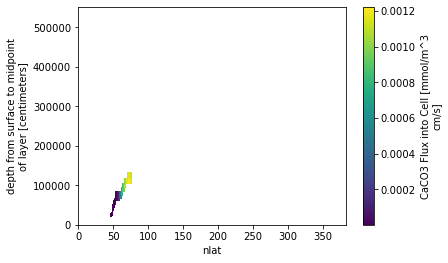

In [75]:
control_CaCO3flux.isel(nlon=120).plot()

In [76]:
SAZ_CaCO3_flux_control =  esmlab.weighted_mean(control_CaCO3flux, weights=area, dim=['nlat', 'nlon']).compute()
#dims: z_t,nlat,nlon

In [77]:
SAZ_CaCO3_flux_control = esmlab.weighted_mean(SAZ_CaCO3_flux_control, weights=dz, dim=['z_t']).compute()
#dims: none

In [78]:
#convert from mmol/m3 cm/s to gCaCO3/m2/yr
SAZ_CaCO3_flux_control = SAZ_CaCO3_flux_control * 0.01 * 86400 * 365 * 0.001 * 100.09
SAZ_CaCO3_flux_control.attrs['units'] = 'gCaCO3 m-2 y-1'

In [79]:
SAZ_CaCO3_flux_control

<xarray.DataArray ()>
array(12.91324121)
Attributes:
    units:    gCaCO3 m-2 y-1

In [80]:
SAZ_CaCO3_flux_2xGCB = SAZ_CaCO3_flux_control*2.

In [81]:
SAZ_CaCO3_flux_noGCB = SAZ_CaCO3_flux_control*0.

### CaCO3 fluxes in SAZ at sigma 27.4: diff from control

In [82]:
SAZ_CaCO3_flux_2xGCB - SAZ_CaCO3_flux_control

<xarray.DataArray ()>
array(12.91324121)
Attributes:
    units:    gCaCO3 m-2 y-1

In [83]:
SAZ_CaCO3_flux_noGCB - SAZ_CaCO3_flux_control

<xarray.DataArray ()>
array(-12.91324121)
Attributes:
    units:    gCaCO3 m-2 y-1

In [84]:
SAZ_fluxes=[SAZ_CaCO3_flux_noGCB.values,SAZ_CaCO3_flux_control.values,SAZ_CaCO3_flux_2xGCB.values]

In [85]:
SAZ_fluxes

[array(0.), array(12.91324121), array(25.82648242)]

In [87]:
#SAZ_ALKdiffs = [SAZ_noGCB_ALK_top_bottom_diff,SAZ_control_ALK_top_bottom_diff,SAZ_2xGCB_ALK_top_bottom_diff]

In [88]:
glb_ALKdiffs = [glb_noGCB_ALK_top_bottom_diff,glb_control_ALK_top_bottom_diff,glb_2xGCB_ALK_top_bottom_diff]

### Make plot Alkalinity difference in SAZ (upper-lower cell) versus CaCO3 flux at sigma27.4

[Text(0, 0.5, 'Alkalinity (lower-upper; Pmol)'),
 Text(0.5, 0, 'CaCO$_3$ flux between 50°S and 30°S (g CaCO$_3$ m$^{-2}$ y$^{-1}$)')]

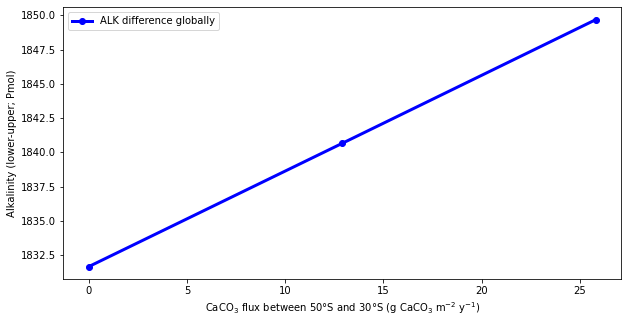

In [89]:
fig = plt.figure(figsize=(10,5))
#plt.suptitle('SAZ CaCO3 FLUX IN', fontsize=14)

ax = fig.add_subplot(1,1,1)
#ax.plot(SAZ_fluxes, SAZ_ALKdiffs, label='ALK difference in SAZ', linewidth=3,marker='o',color='red')
ax.plot(SAZ_fluxes,glb_ALKdiffs, label='ALK difference globally', linewidth=3,marker='o',color='blue')
ax.legend()

ax.set(ylabel='Alkalinity (lower-upper; Pmol)',xlabel='CaCO$_3$ flux between 50°S and 30°S (g CaCO$_3$ m$^{-2}$ y$^{-1}$)')

In [90]:
cesm_ann_ds

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    TLONG              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t_150m           (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_t                (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    REGION_MASK        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz                 (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    CaCO3_FLUX_IN      (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    PD                 (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    ALK                (z_t, nlat, nlon) float32 ...
    ALK_ALT_CO2_noGCB  (z_t, nlat, nlon) float32 ...
    ALK_ALT_CO2_2xGCB  (z_t, nlat, nlon) float32 ...
    sigma              (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    ALK_diff_noGCB     (z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan
    ALK_diff_2xGCB     (z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan

## Find latitudinal shift along 45S

#### Alk that's north of 45S for noGCB

In [91]:
N45S_ALK_noGCB = cesm_ann_ds.ALK_ALT_CO2_noGCB.where(lats>-45.)
#dims: z_t,nlat,nlon
N45S_ALK_noGCB = esmlab.weighted_sum(N45S_ALK_noGCB, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
N45S_ALK_noGCB = esmlab.weighted_sum(N45S_ALK_noGCB, weights=dz_m, dim=['z_t']).compute()
#dims: none
N45S_ALK_noGCB = N45S_ALK_noGCB.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
N45S_ALK_noGCB #Pmol

2667.7533674518254

#### Alk that's south of 45S for noGCB

In [92]:
S45S_ALK_noGCB = cesm_ann_ds.ALK_ALT_CO2_noGCB.where(lats<=-45.)
#dims: z_t,nlat,nlon
S45S_ALK_noGCB = esmlab.weighted_sum(S45S_ALK_noGCB, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
S45S_ALK_noGCB = esmlab.weighted_sum(S45S_ALK_noGCB, weights=dz_m, dim=['z_t']).compute()
#dims: none
S45S_ALK_noGCB = S45S_ALK_noGCB.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
S45S_ALK_noGCB #Tmol

544.0970204092372

#### Alk that's north of 45S for control

In [93]:
N45S_ALK_control = cesm_ann_ds.ALK.where(lats>-45.)
#dims: z_t,nlat,nlon
N45S_ALK_control = esmlab.weighted_sum(N45S_ALK_control, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
N45S_ALK_control = esmlab.weighted_sum(N45S_ALK_control, weights=dz_m, dim=['z_t']).compute()
#dims: none
N45S_ALK_control = N45S_ALK_control.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
N45S_ALK_control #Tmol

2663.8649914887237

#### Alk that's south of 45S for control

In [94]:
S45S_ALK_control = cesm_ann_ds.ALK.where(lats<=-45.)
#dims: z_t,nlat,nlon
S45S_ALK_control = esmlab.weighted_sum(S45S_ALK_control, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
S45S_ALK_control = esmlab.weighted_sum(S45S_ALK_control, weights=dz_m, dim=['z_t']).compute()
#dims: none
S45S_ALK_control = S45S_ALK_control.values * 0.001 * 1e-15 #convert from mmol Alk to Tmol Alk
S45S_ALK_control #Tmol

545.0578616659617

#### Alk that's north of 45S for 2xGCB

In [95]:
N45S_ALK_2xGCB = cesm_ann_ds.ALK_ALT_CO2_2xGCB.where(lats>-45.)
#dims: z_t,nlat,nlon
N45S_ALK_2xGCB = esmlab.weighted_sum(N45S_ALK_2xGCB, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
N45S_ALK_2xGCB = esmlab.weighted_sum(N45S_ALK_2xGCB, weights=dz_m, dim=['z_t']).compute()
#dims: none
N45S_ALK_2xGCB = N45S_ALK_2xGCB.values * 0.001 * 1e-15 #convert from mmol Alk to Tmol Alk
N45S_ALK_2xGCB #Tmol

2659.969386582606

#### Alk that's south of 45S for 2xGCB

In [96]:
S45S_ALK_2xGCB = cesm_ann_ds.ALK_ALT_CO2_2xGCB.where(lats<=-45.)
#dims: z_t,nlat,nlon
S45S_ALK_2xGCB = esmlab.weighted_sum(S45S_ALK_2xGCB, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
S45S_ALK_2xGCB = esmlab.weighted_sum(S45S_ALK_2xGCB, weights=dz_m, dim=['z_t']).compute()
#dims: none
S45S_ALK_2xGCB = S45S_ALK_2xGCB.values * 0.001 * 1e-15 #convert from mmol Alk to Tmol Alk
S45S_ALK_2xGCB #tTmol

546.0157833266885

### Find N/S differences

In [97]:
noGCB_ALK_NS_diff = N45S_ALK_noGCB - S45S_ALK_noGCB
noGCB_ALK_NS_diff

2123.656347042588

In [98]:
control_ALK_NS_diff = N45S_ALK_control - S45S_ALK_control
control_ALK_NS_diff

2118.807129822762

In [99]:
GCB2x_ALK_NS_diff = N45S_ALK_2xGCB - S45S_ALK_2xGCB
GCB2x_ALK_NS_diff

2113.9536032559176

### Alk diffs of diffs from N/S shift

In [ ]:
noGCB_ALK_NS_diff - control_ALK_NS_diff

In [ ]:
GCB2x_ALK_NS_diff - control_ALK_NS_diff

### Get CaCO3 flux profiles PFZ (sigma 26.2 to 27.1) and SAZ (sigma 26 to 26.8) for Figure 2

In [54]:
SAZ_CaCO3_flux_in = cesm_ann_ds.CaCO3_FLUX_IN.where(sigma_surf<27.1).where(sigma_surf>26.2).where(cesm_ann_ds.TLAT<0.)

In [55]:
SAZ_CaCO3_flux_in

<xarray.DataArray 'CaCO3_FLUX_IN' (z_t: 60, nlat: 384, nlon: 320)>
dask.array<where, shape=(60, 384, 320), dtype=float32, chunksize=(60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     CaCO3 Flux into Cell
    units:         mmol/m^3 cm/s
    grid_loc:      3111
    cell_methods:  time: mean

In [114]:
CaCO3_FLUX_IN_profile_global_mean =  esmlab.weighted_mean(cesm_ann_ds['CaCO3_FLUX_IN'], weights=area, dim=['nlat', 'nlon']).compute()

In [145]:
# CaCO3_FLUX_IN_profile_PFZ =  esmlab.weighted_mean(SAZ_CaCO3_flux_in, weights=area, dim=['nlat', 'nlon']).compute()
# #convert from mmol/m3 cm/s to gC/m2/yr
# CaCO3_FLUX_IN_profile_PFZ = CaCO3_FLUX_IN_profile_SAZ * 0.01 * 86400 * 365 * 0.001 * 12.011

In [146]:
# out = CaCO3_FLUX_IN_profile_SAZ.values
# filename = "output_data/CaCO3_flux_gCm2yr_SAZ.txt"
# np.savetxt(filename,out, delimiter=',')

In [147]:
CaCO3_FLUX_IN_profile_PFZ =  esmlab.weighted_mean(SAZ_CaCO3_flux_in, weights=area, dim=['nlat', 'nlon']).compute()
#convert from mmol/m3 cm/s to gCaCO3/m2/yr
CaCO3_FLUX_IN_profile_PFZ = CaCO3_FLUX_IN_profile_PFZ * 0.01 * 86400 * 365 * 0.001 * 100.09

In [148]:
out = CaCO3_FLUX_IN_profile_PFZ.values
filename = "output_data/CaCO3_flux_gCaCO3m2yr_PFZ.txt"
np.savetxt(filename,out, delimiter=',')

In [59]:
# fig = plt.figure(figsize=(5,5))

# plt.suptitle('Global mean CaCO3 FLUX IN', fontsize=14)


# #COLUMN 1  - ALKs

# ax = fig.add_subplot(1,1,1)
# ax.plot(CaCO3_FLUX_IN_profile_global_mean.values, depths, label='CaCO3_FLUX_IN', linewidth=3,marker='o')
# #ax.plot(ds_glb['ALK_glodap'].values, depths, label='ALK_glodap', linewidth=3)
# ax.legend()

# ax.set(ylabel='depth (m)',xlabel='CaCO3_FLUX_IN (mmol/m^3 cm/s)')
# plt.gca().invert_yaxis()


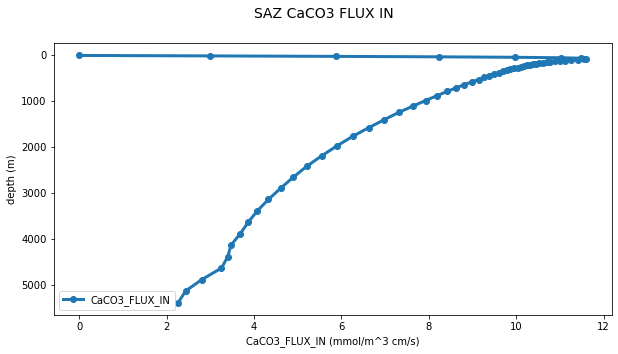

In [149]:
fig = plt.figure(figsize=(10,5))

plt.suptitle('SAZ CaCO3 FLUX IN', fontsize=14)


#COLUMN 1  - ALKs

ax = fig.add_subplot(1,1,1)
ax.plot(CaCO3_FLUX_IN_profile_PFZ.values, depths, label='CaCO3_FLUX_IN', linewidth=3,marker='o')
#ax.plot(ds_glb['ALK_glodap'].values, depths, label='ALK_glodap', linewidth=3)
ax.legend()

ax.set(ylabel='depth (m)',xlabel='CaCO3_FLUX_IN (mmol/m^3 cm/s)')
plt.gca().invert_yaxis()


In [119]:
SAZ_CaCO3_flux_in = cesm_ann_ds.CaCO3_FLUX_IN.where(sigma_surf<26.8).where(sigma_surf>26).where(cesm_ann_ds.TLAT<0.)
# was SAZ2

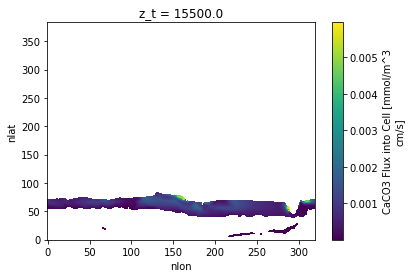

In [120]:
SAZ_CaCO3_flux_in.isel(z_t=15).plot()

In [122]:
# CaCO3_FLUX_IN_profile_SAZ =  esmlab.weighted_mean(SAZ_CaCO3_flux_in, weights=area, dim=['nlat', 'nlon']).compute()

# #convert from mmol/m3 cm/s to gC/m2/yr
# CaCO3_FLUX_IN_profile_SAZ = CaCO3_FLUX_IN_profile_SAZ * 0.01 * 86400 * 365 * 0.001 * 12.011

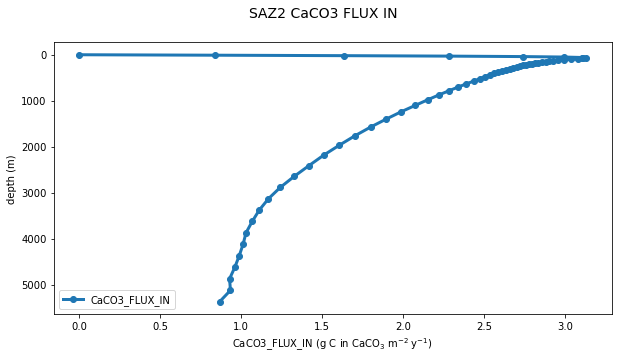

In [124]:
# fig = plt.figure(figsize=(10,5))

# plt.suptitle('SAZ2 CaCO3 FLUX IN', fontsize=14)


# #COLUMN 1  - ALKs

# ax = fig.add_subplot(1,1,1)
# ax.plot(CaCO3_FLUX_IN_profile_SAZ.values, depths, label='CaCO3_FLUX_IN', linewidth=3,marker='o')
# #ax.plot(ds_glb['ALK_glodap'].values, depths, label='ALK_glodap', linewidth=3)
# ax.legend()

# ax.set(ylabel='depth (m)',xlabel='CaCO3_FLUX_IN (g C in CaCO$_3$ m$^{-2}$ y$^{-1}$)')
# plt.gca().invert_yaxis()


In [140]:
# out = CaCO3_FLUX_IN_profile_SAZ2.values
# filename = "output_data/CaCO3_flux_gCm2yr_SAZ.txt"
# np.savetxt(filename,out, delimiter=',')

In [126]:
CaCO3_FLUX_IN_profile_SAZ =  esmlab.weighted_mean(SAZ_CaCO3_flux_in, weights=area, dim=['nlat', 'nlon']).compute()

#convert from mmol/m3 cm/s to gCaCO3/m2/yr
CaCO3_FLUX_IN_profile_SAZ = CaCO3_FLUX_IN_profile_SAZ * 0.01 * 86400 * 365 * 0.001 * 100.09

In [138]:
out = CaCO3_FLUX_IN_profile_SAZ.values
filename = "output_data/CaCO3_flux_gCaCO3m2yr_SAZ.txt" #was SAZ2
np.savetxt(filename,out, delimiter=',')

In [141]:
out = depths.values
filename = "output_data/depths.txt"
np.savetxt(filename,out, delimiter=',')

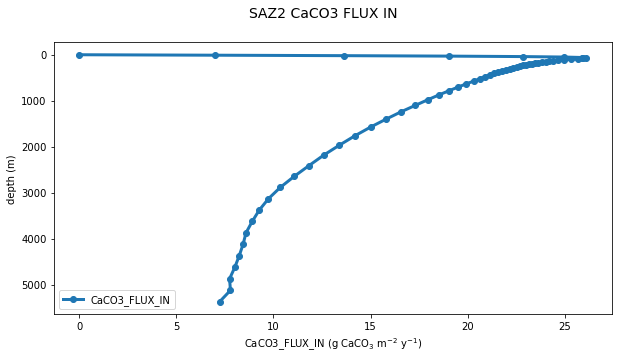

In [127]:
fig = plt.figure(figsize=(10,5))

plt.suptitle('SAZ2 CaCO3 FLUX IN', fontsize=14)


#COLUMN 1  - ALKs

ax = fig.add_subplot(1,1,1)
ax.plot(CaCO3_FLUX_IN_profile_SAZ.values, depths, label='CaCO3_FLUX_IN', linewidth=3,marker='o')
#ax.plot(ds_glb['ALK_glodap'].values, depths, label='ALK_glodap', linewidth=3)
ax.legend()

ax.set(ylabel='depth (m)',xlabel='CaCO3_FLUX_IN (g CaCO$_3$ m$^{-2}$ y$^{-1}$)')
plt.gca().invert_yaxis()
